In [1]:
import time
import math
import copy
import torch
import pickle
import random
import logging
import warnings
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import fairlearn.datasets
from tqdm import tqdm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from torch.autograd import grad, Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd.functional import vhp

from torch.utils.data import Subset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score
from scipy.stats import spearmanr

plt.rcParams['figure.dpi'] = 300
warnings.filterwarnings("ignore")

E = math.e

### Utility Functions

In [2]:
def get_MNIST():
    train_dataset = dsets.MNIST(root='', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = dsets.MNIST(root='', train=False, transform=transforms.ToTensor(), download=True)
    
    idx = (train_dataset.targets==1) | (train_dataset.targets==7) | (train_dataset.targets==3) | (train_dataset.targets==8)
    train_dataset.targets = train_dataset.targets[idx]
    train_dataset.data = train_dataset.data[idx]
    
    new_targets = []
    
    for old_lab in train_dataset.targets:
        if old_lab == 1:
            new_targets.append(0)
        elif old_lab == 3:
            new_targets.append(1)
        elif old_lab == 7:
            new_targets.append(2)
        elif old_lab == 8:
            new_targets.append(3)
            
    train_dataset.targets = new_targets
    
    idx = (test_dataset.targets==1) | (test_dataset.targets==7) | (test_dataset.targets==3) | (test_dataset.targets==8)
    test_dataset.targets = test_dataset.targets[idx]
    test_dataset.data = test_dataset.data[idx]
    
    new_targets = []
    
    for old_lab in test_dataset.targets:
        if old_lab == 1:
            new_targets.append(0)
        elif old_lab == 3:
            new_targets.append(1)
        elif old_lab == 7:
            new_targets.append(2)
        elif old_lab == 8:
            new_targets.append(3)
            
    test_dataset.targets = new_targets
    
    return train_dataset, test_dataset

In [3]:
def visualize_result(e_k_actual, e_k_estimated, ep, k_):

    #e_k_estimated = [-1*ek for ek in e_k_estimated]
    fig, ax = plt.subplots()
    palette = sns.color_palette("cool", len(e_k_actual))
    sns.set(font_scale=1.15)
    sns.set_style(style='white')
    min_x = np.min(e_k_actual)
    max_x = np.max(e_k_actual)
    min_y = np.min(e_k_estimated)
    max_y = np.max(e_k_estimated)
    
    plt.rcParams['figure.figsize'] = 6, 5
    z = np.polyfit(e_k_actual,  e_k_estimated, 1)
    p = np.poly1d(z)
    xx = np.linspace(-p(2)/p(1), max(e_k_actual)+.0001)
    yy = np.polyval(p, xx)
    #add trendline to plot
    ax.plot(xx, yy, ls="-", color='k')
    for k in range(len(e_k_actual)):
        ax.scatter(e_k_actual[k], e_k_estimated[k], zorder=2, s=45, color = palette[k], label=ep[k])

    ax.set_title(f'Actual vs. Estimated loss for k={k_:.2f}%')
    ax.set_xlabel('Actual loss difference')
    ax.set_ylabel('Estimated loss difference')
   
    ax.set_xlim(min_x-.0001, max_x+.0001)
    ax.set_ylim(min_y-.0001, max_y+.0001)
    
   
    text = 'MAE = {:.03}\nP = {:.03}'.format(mean_absolute_error(e_k_actual, e_k_estimated), spearmanr(e_k_actual, e_k_estimated).correlation)
    ax.text(max_x+.00009,min_y-.00008, text, verticalalignment='bottom', horizontalalignment='right')
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.tight_layout()
    plt.xticks(rotation = 45)
    plt.show()
    # cooler color = smaller epsilon

In [4]:
 class CreateData(torch.utils.data.Dataset):
    def __init__(self, data, targets, pert_status):
        self.data = data
        self.targets = targets
        self.pert = pert_status

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.targets[idx]
        pert_label = self.pert[idx]

        return out_data, out_label, pert_label

In [5]:
def get_data(new_train_df, k):    

    selected_group = new_train_df.loc[new_train_df['label'] == 0]

    num_to_sample = round((k / 100)*len(new_train_df))

    sampled_group = selected_group.sample(n=num_to_sample, replace=True)
    not_selected = new_train_df.drop(sampled_group.index)

    feats = set(new_train_df.columns) - {'label'}
    selected_group_X = sampled_group[feats]
    selected_group_y = sampled_group['label']

    not_selected_group_X = not_selected[feats]
    not_selected_group_y = not_selected['label']   
    
    return selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y

### Randomized Response

In [6]:
def get_p(epsilon):
    prob_stay = (E ** epsilon) / (3 + (E ** epsilon))
    prob_change = 1 / (3 + (E ** epsilon))
    
    p = torch.zeros(4,4)
    for i in range(4):
        for j in range(4):
            if i == j: 
                p[i][j] = prob_stay
            else:
                p[i][j] = prob_change
    
    return p

In [7]:
def forward_correct_loss(y_act, oupt, epsilon, criterion, device):
    
    p = get_p(epsilon)
    y_pred_c = torch.matmul(oupt, p.to(device)) 
    loss = criterion(torch.log(y_pred_c), y_act)
    
    return loss 

### Models

In [8]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        
        self.fc1 = torch.nn.Linear(784, 4)
        self.criterion = torch.nn.NLLLoss(reduction='mean')
        self.activ = torch.nn.Softmax()
        
    def forward(self, x):
        probs = self.activ(self.fc1(x))

        return probs
    
    def loss(self, test_loader, print_, device):
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        all_loss = 0
        for images, labels in test_loader:
            images = Variable(images.view(-1, 28*28)).to(device)
            labels = Variable(labels).to(device)
            outputs = self.fc1(images)
            loss = self.criterion(outputs, labels)
            all_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total+= labels.size(0)
            
            all_labels.extend(list(labels.detach().cpu().numpy()))
            all_predicted.extend(list(predicted.detach().cpu().numpy()))
            correct+= (predicted.detach().cpu().numpy() == labels.detach().cpu().numpy()).sum()
        acc = 100 * correct/total
        
#         print("Accuracy is {0:.3f}".format(acc))
#         print("Precision is {0:.3f}".format(precision_score(all_labels, all_predicted, average='micro')))
#         print("Recall is {0:.3f}".format(recall_score(all_labels, all_predicted, average='micro')))
        return loss/len(test_loader), acc

In [9]:
def train(model, dataset, epsilon, lengths, device):
    model.train()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=.0005, weight_decay=0)
    criterion = torch.nn.NLLLoss(reduction='mean')
    pert_status = np.zeros(len(dataset[0]))
 
    if lengths is not None:
        len_original = lengths[0]
        len_perts = lengths[1]
        total_len = len(dataset[0])
        pert_status = []
        pert_status.extend(np.zeros(len_original))
        pert_status.extend(np.ones(len_perts))
    
    train_data = CreateData(dataset[0], dataset[1], pert_status)
    train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
        
    for itr in range(0, 10):
        itr_loss = 0
        correct = 0
        total = 0
        for i, (images, labels, pert_val) in enumerate(train_dataloader):
            images = Variable(images.view(-1, 28*28)).to(device)
            labels = Variable(labels).to(device)
           
            optimizer.zero_grad()
            outputs = model(images)
            
            if pert_val == 0:
                loss_val = criterion(torch.log(outputs), labels)
            else:
                loss_val = forward_correct_loss(labels, outputs, epsilon, torch.nn.NLLLoss(reduction='sum'), device)

            itr_loss += loss_val
            loss_val.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total+= labels.size(0)
            correct+= (predicted.detach().cpu() == labels.detach().cpu()).sum()
            
#         print(f'Epoch {itr+1} - Loss: {itr_loss/len(train_dataloader):.3f} - Acc: {100*correct/total:.3f}')
            
    return model

### Influence Calculation Functions


In [10]:
def calc_influence_single(model, epsilon, train_dataset, train_dataloader, test_dataloader, group_data, device, criterion, hessian):
    start = time.time()
    
    if hessian is None:
        s_test_vec = s_test_sample(model, test_dataloader, train_dataset, device, criterion)
    else:
        s_test_vec = hessian
   
    grad_z_vec = grad_training([group_data[0], group_data[1]], model, device, epsilon)
    
    with torch.no_grad():
        influence = (sum([torch.sum(k * j).data for k, j in zip(grad_z_vec, s_test_vec)]) / len(train_dataset))
            
    end = time.time() - start

    return influence.cpu(), end, s_test_vec

In [11]:
def s_test_sample(model, test_dataloader, train_dataset, device, criterion):
    scale = 25
    damp = 0.01
    recursion_depth = 7500
    r = 3
    
    inverse_hvp = [torch.zeros_like(params, dtype=torch.float) for params in model.parameters()]
    
    for i in range(r):
        hessian_loader = DataLoader(train_dataset, sampler=torch.utils.data.RandomSampler(train_dataset, True, num_samples=recursion_depth), batch_size = 1, num_workers=4)
        
        cur_estimate = s_test(test_dataloader, model, i, hessian_loader, device, damp, scale, criterion)
        
        with torch.no_grad():
            inverse_hvp = [old + (cur/scale) for old,cur in zip(inverse_hvp, cur_estimate)]
    
    with torch.no_grad():
        inverse_hvp = [component / r for component in inverse_hvp]
        
    return inverse_hvp

In [12]:
def s_test(test_dataloader, model, i, hessian_loader, device, damp, scale, criterion):
    v = grad_z(test_dataloader, model, device, criterion)
    h_estimate = v
    
    params, names = make_functional(model)
    params = tuple(p.detach().requires_grad_() for p in params)
    
    progress_bar = tqdm(hessian_loader, desc=f"IHVP sample {i}")
    
    for i, (x_train, y_train) in enumerate(progress_bar):
        x_train = Variable(x_train.view(-1, 28*28)).to(device)
        y_train = Variable(y_train).to(device)
        
        def f(*new_params):
            load_weights(model, names, new_params)
            out = model(x_train)
            loss = criterion(out, y_train)
            return loss
    
        hv = vhp(f, params, tuple(h_estimate), strict=True)[1]
        
        with torch.no_grad():
            h_estimate = [
                _v + (1-damp) * _h_e - _hv / scale for _v, _h_e, _hv in zip(v, h_estimate, hv)
            ]
            
            if i % 100 == 0:
                norm = sum([h_.norm() for h_ in h_estimate])
                progress_bar.set_postfix({"est norm": norm.item()})
                
    with torch.no_grad():
        load_weights(model, names, params, as_params=True)
        
    return h_estimate

In [13]:
def make_functional(model):
    orig_params = tuple(model.parameters())
    names = []
    
    for name, p in list(model.named_parameters()):
        del_attr(model, name.split("."))
        names.append(name)
    
    return orig_params, names

In [14]:
def del_attr(obj, names):
    if len(names) == 1:
        delattr(obj, names[0])
    else:
        del_attr(getattr(obj, names[0]), names[1:])

In [15]:
def set_attr(obj, names, val):
    if len(names) == 1:
        setattr(obj, names[0], val)
    else:
        set_attr(getattr(obj, names[0]), names[1:], val)

In [16]:
def load_weights(model, names, params, as_params=False):
    for name, p in zip(names, params):
        if not as_params:
            set_attr(model, name.split("."), p)
        else:
            set_attr(model, name.split("."), torch.nn.Parameter(p))

In [17]:
def grad_z(test_data, model, device, criterion):

    model.eval()

    itr_loss = 0
    for i, (images, labels) in enumerate(test_data):
        images = Variable(images.view(-1, 28*28)).to(device)
        labels = Variable(labels).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        itr_loss += loss

    loss_ = itr_loss / len(test_data)
    return grad(loss_, model.parameters())

In [18]:
def grad_training(train_data, model, device, epsilon):

    model.eval()

    x_train_input = torch.FloatTensor(train_data[0].values).to(device)
    y_train_input = torch.LongTensor(train_data[1].values).to(device)
    pert_status = np.ones(len(train_data[0]))
    
    train_data = CreateData(x_train_input, y_train_input, pert_status)
    train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)

    criterion = torch.nn.CrossEntropyLoss(reduction='sum')
    
    agg_loss=0
    possible_labels = [0,1,2,3]
    for i, (image, label, _) in enumerate(train_dataloader):
        pert_agg_loss = 0
        
        output = model(image)
        orig_loss = criterion(output, label)

        for j in possible_labels:
            if j != label.item():
                pert_label = torch.LongTensor([j]).to(device)
                pert_loss = forward_correct_loss(pert_label, output, epsilon, criterion, device)
                pert_agg_loss += (pert_loss - orig_loss)
            
        itr_loss = pert_agg_loss
        agg_loss += itr_loss
        
    loss = float(1/(3 + (E ** epsilon)))*(agg_loss)
    
    to_return = grad(loss, model.parameters())
    
        
    return to_return

### Main Function

In [19]:
def Main(dataset, epsilons, ks, num_rounds):

    device = 'cuda:7' if torch.cuda.is_available() else 'cpu'
    criterion = torch.nn.NLLLoss(reduction='mean')
    
    all_orig_loss_e_k = []
    all_est_loss_e_k = []
    all_time = []
    
    for nr in range(num_rounds):
        print(f'\nRound {nr+1}')
        ############
        # Get data #
        ############
        print('\nGetting Data...')

        train_dataset, test_dataset = get_MNIST()
        
        images_train = []
        labels_train = []
        
        images_test = []
        labels_test = []
        
        for i, (image, label) in enumerate(train_dataset):
            images_train.append(image.view(-1, 28*28).tolist()[0])
            labels_train.append(label)
        
        X_train = pd.DataFrame(images_train)
        y_train = pd.DataFrame(labels_test, columns =['label'])
        
        for i, (image, label) in enumerate(test_dataset):
            images_test.append(image.view(-1, 28*28).tolist()[0])
            labels_test.append(label)
        
        X_train = pd.DataFrame(images_train)
        y_train = pd.DataFrame(labels_train, columns =['label'])
        
        X_test = pd.DataFrame(images_test)
        y_test= pd.DataFrame(labels_test, columns =['label'])
        
        x_test_input = torch.FloatTensor(X_test.values).to(device)
        y_test_input = y_test.values.tolist()
        y_test_input = [yti for sublist in y_test_input for yti in sublist]
        y_test_input = torch.LongTensor(y_test_input).to(device)

        x_train_input = torch.FloatTensor(X_train.values).to(device)
        y_train_input = y_train.values.tolist()
        y_train_input = [yti for sublist in y_train_input for yti in sublist]
        y_train_input = torch.LongTensor(y_train_input).to(device)
   
        new_train_df = pd.concat([X_train, y_train], axis=1)
      
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
   
        ##############################################
        # Train original model and get original loss #
        ##############################################
        print('Training original model...')
        torch_model = LogisticRegression()
        torch.save(torch_model.state_dict(), 'initial_config.pth')
        torch_model.to(device)
        torch_model = train(torch_model, [x_train_input, y_train_input], None, None, device)
        test_loss_ori, acc_ori = torch_model.loss(test_loader, True, device)

        e_k_act_losses = []
        e_k_est_losses = []
        influence_time = []
        
        ################################################################
        # Perform influence and retraining for all epsilons a k values #
        ################################################################
        print('\nBegining epsilon and k rounds')
        print('-----------------------------')
        for k_elem, k in enumerate(ks):
            print(f'\nk: {k}')
            hessian = None
            k_act_losses = []
            k_est_losses = []
            inf_time = []
            
            for ep_elem, ep in enumerate(epsilons):
                # Influence
                print(f'ep: {ep}')
                selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y = get_data(new_train_df, k)
                loss_diff_approx, tot_time, hessian = calc_influence_single(torch_model, ep, train_dataset, train_loader, test_loader, [selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y], device, criterion, hessian)
                loss_diff_approx = -torch.FloatTensor(loss_diff_approx).cpu().numpy()
                print(f'Approx difference: {loss_diff_approx:.5f}')
                
                # Retrain - need to actually perturb
                p_stay = ((E**ep)/(3+(E**ep)))
                p_change = (1/(3+(E**ep)))

                G_pert = []
                G_labels = selected_group_y.values.tolist()
                
                for lab in G_labels:
                    poss_labels = [0,1,2,3]
                        
                    weights = [p_change for i in range(len(poss_labels))]
                    weights[lab] = p_stay
                    
                    pert_lab = random.choices(poss_labels, weights=weights, k=1)
                    G_pert.append(pert_lab[0])
                    
                y_w_group_pert = pd.concat([not_selected_group_y, pd.DataFrame(G_pert)], axis = 0, ignore_index=True)
                y_w_group_pert = y_w_group_pert.values.tolist()
                y_w_group_pert = [yw for sublist in y_w_group_pert for yw in sublist]
               
                y_wo_pert = pd.concat([not_selected_group_y, selected_group_y], axis = 0, ignore_index=True)
                reconstructed_x = pd.concat([not_selected_group_X, selected_group_X], axis = 0, ignore_index=True)
                x_train_input_pert = torch.FloatTensor(reconstructed_x.values).to(device)
                y_train_input_pert = torch.LongTensor(y_w_group_pert).to(device)

                model_pert = LogisticRegression()
                model_pert.load_state_dict(torch.load('initial_config.pth'))
                model_pert.to(device)
                model_pert = train(model_pert, [x_train_input_pert, y_train_input_pert], ep, [len(not_selected_group_y), len(selected_group_y)], device)
                test_loss_retrain, acc_retrain = model_pert.loss(test_loader, True, device)

                 # get true loss diff
                loss_diff_true = (test_loss_retrain - test_loss_ori).detach().cpu().item()
                print(f'True difference: {loss_diff_true:.5f}')
                k_act_losses.append(loss_diff_true)
                k_est_losses.append(loss_diff_approx)
                inf_time.append(tot_time)
            
            visualize_result(k_act_losses, k_est_losses, epsilons, k)
            e_k_act_losses.append(k_act_losses)
            e_k_est_losses.append(k_est_losses)
            influence_time.append(inf_time)
            
        all_orig_loss_e_k.append(e_k_act_losses)
        all_est_loss_e_k.append(e_k_est_losses) 
        all_time.append(influence_time)
    
    return all_orig_loss_e_k, all_est_loss_e_k, all_time

### Perform Experiment 

#### Constants

In [20]:
epsilons = np.linspace(.001, 5, 30) #30 5
k = [30] #10
rounds = 5


Round 1

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

k: 30
ep: 0.001


IHVP sample 2: 100%|████████████████████████████████████████████████| 7500/7500 [00:18<00:00, 397.68it/s, est norm=2.98]


Approx difference: 0.00129
True difference: 0.00423
ep: 0.17337931034482756
Approx difference: 0.00131
True difference: 0.00452
ep: 0.3457586206896551
Approx difference: 0.00136
True difference: 0.00528
ep: 0.5181379310344827
Approx difference: 0.00136
True difference: 0.00504
ep: 0.6905172413793103
Approx difference: 0.00146
True difference: 0.00472
ep: 0.8628965517241378
Approx difference: 0.00142
True difference: 0.00372
ep: 1.0352758620689653
Approx difference: 0.00148
True difference: 0.00415
ep: 1.207655172413793
Approx difference: 0.00151
True difference: 0.00410
ep: 1.3800344827586204
Approx difference: 0.00150
True difference: 0.00383
ep: 1.5524137931034478
Approx difference: 0.00153
True difference: 0.00348
ep: 1.7247931034482755
Approx difference: 0.00150
True difference: 0.00352
ep: 1.8971724137931032
Approx difference: 0.00148
True difference: 0.00251
ep: 2.0695517241379306
Approx difference: 0.00148
True difference: 0.00455
ep: 2.241931034482758
Approx difference: 0.00139

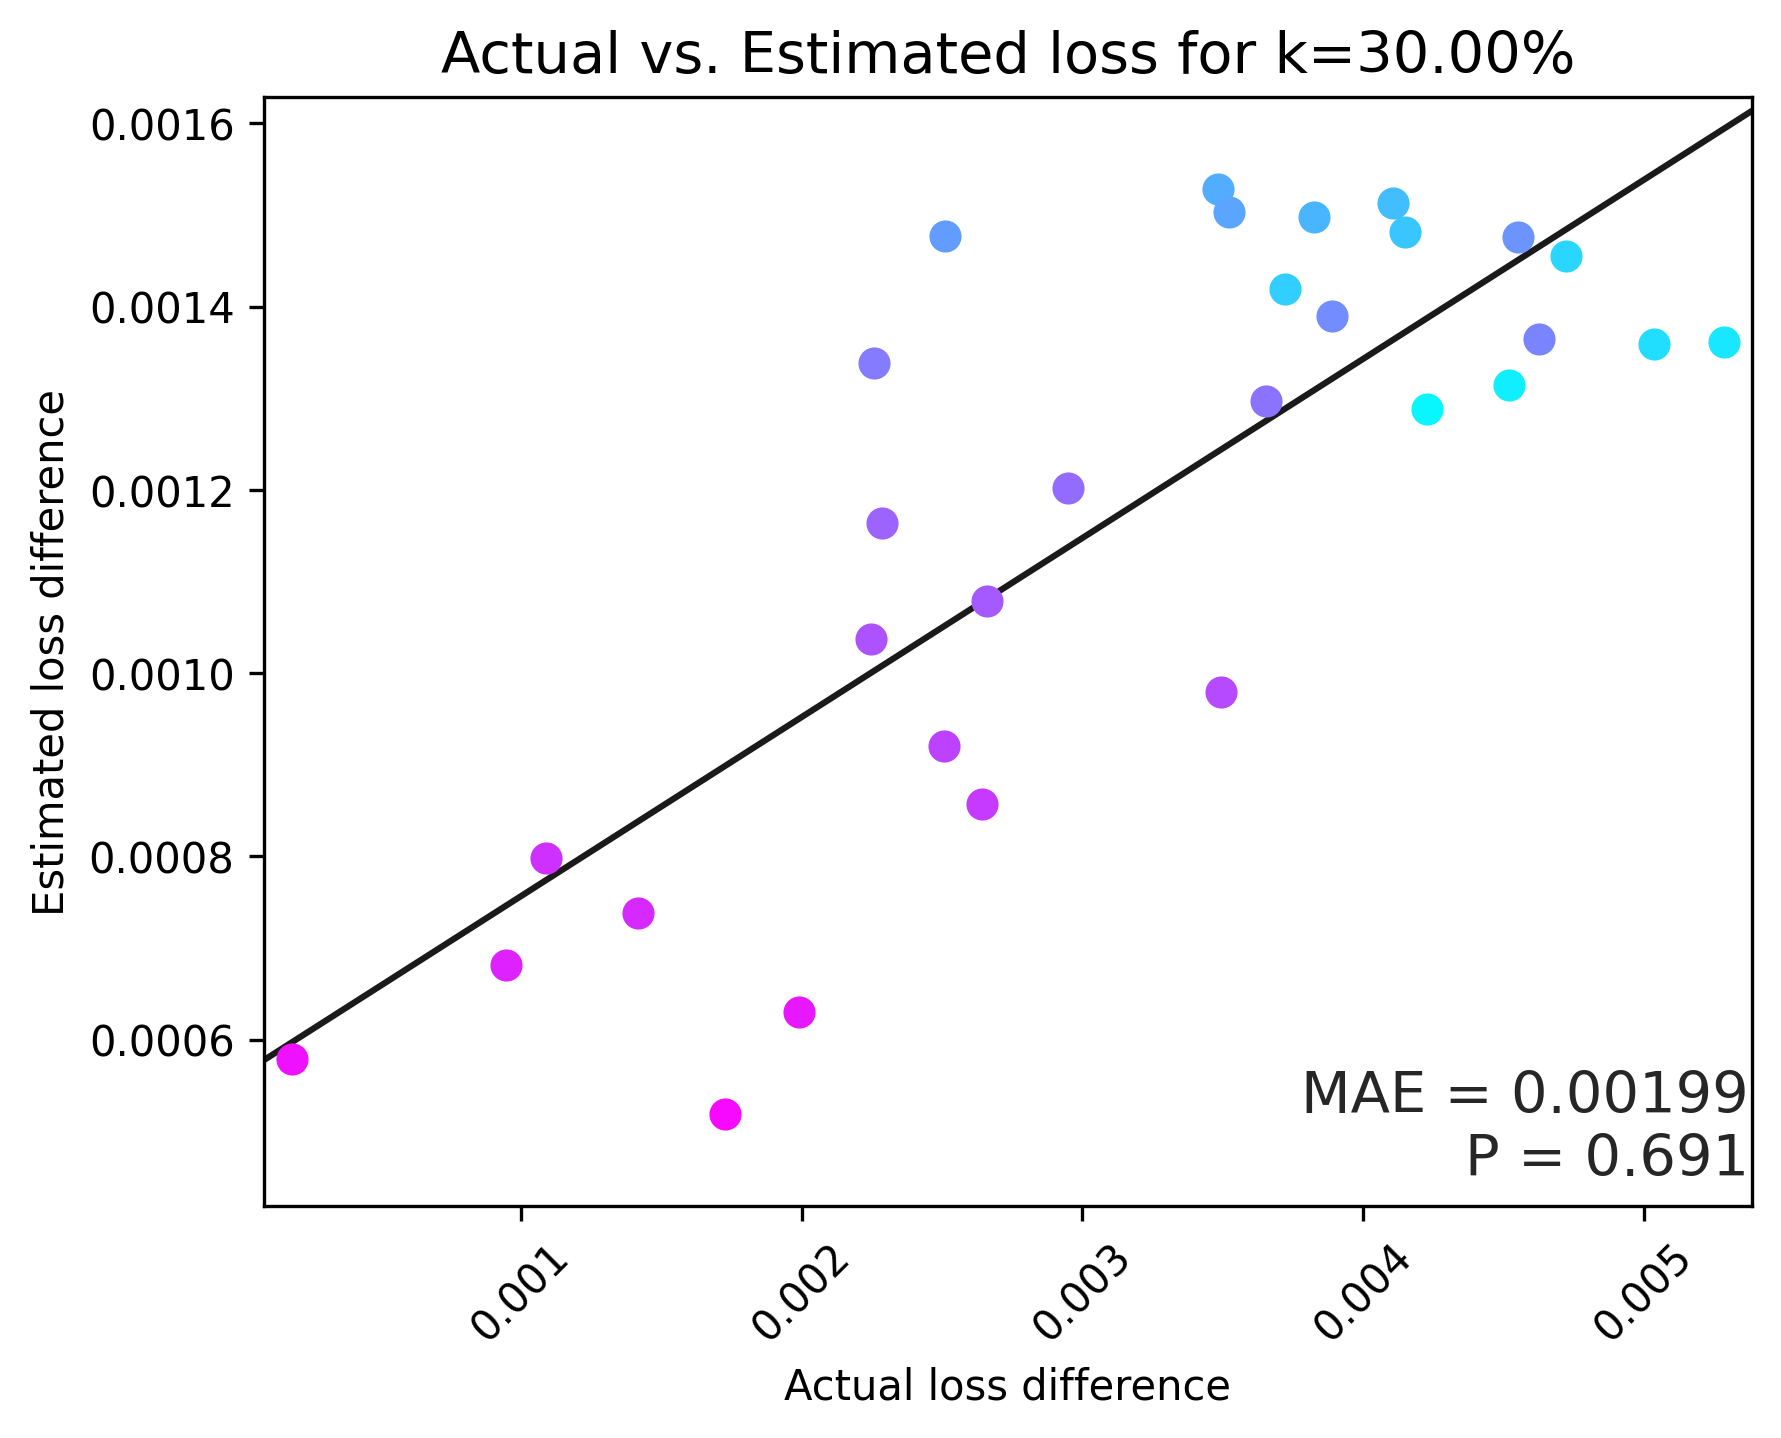


Round 2

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

k: 30
ep: 0.001


IHVP sample 2: 100%|████████████████████████████████████████████████| 7500/7500 [00:20<00:00, 361.33it/s, est norm=3.17]


Approx difference: 0.00198
True difference: 0.00444
ep: 0.17337931034482756
Approx difference: 0.00206
True difference: 0.00440
ep: 0.3457586206896551
Approx difference: 0.00216
True difference: 0.00566
ep: 0.5181379310344827
Approx difference: 0.00219
True difference: 0.00488
ep: 0.6905172413793103
Approx difference: 0.00219
True difference: 0.00414
ep: 0.8628965517241378
Approx difference: 0.00228
True difference: 0.00485
ep: 1.0352758620689653
Approx difference: 0.00228
True difference: 0.00404
ep: 1.207655172413793
Approx difference: 0.00231
True difference: 0.00440
ep: 1.3800344827586204
Approx difference: 0.00229
True difference: 0.00345
ep: 1.5524137931034478
Approx difference: 0.00229
True difference: 0.00450
ep: 1.7247931034482755
Approx difference: 0.00226
True difference: 0.00275
ep: 1.8971724137931032
Approx difference: 0.00224
True difference: 0.00249
ep: 2.0695517241379306
Approx difference: 0.00220
True difference: 0.00327
ep: 2.241931034482758
Approx difference: 0.00217

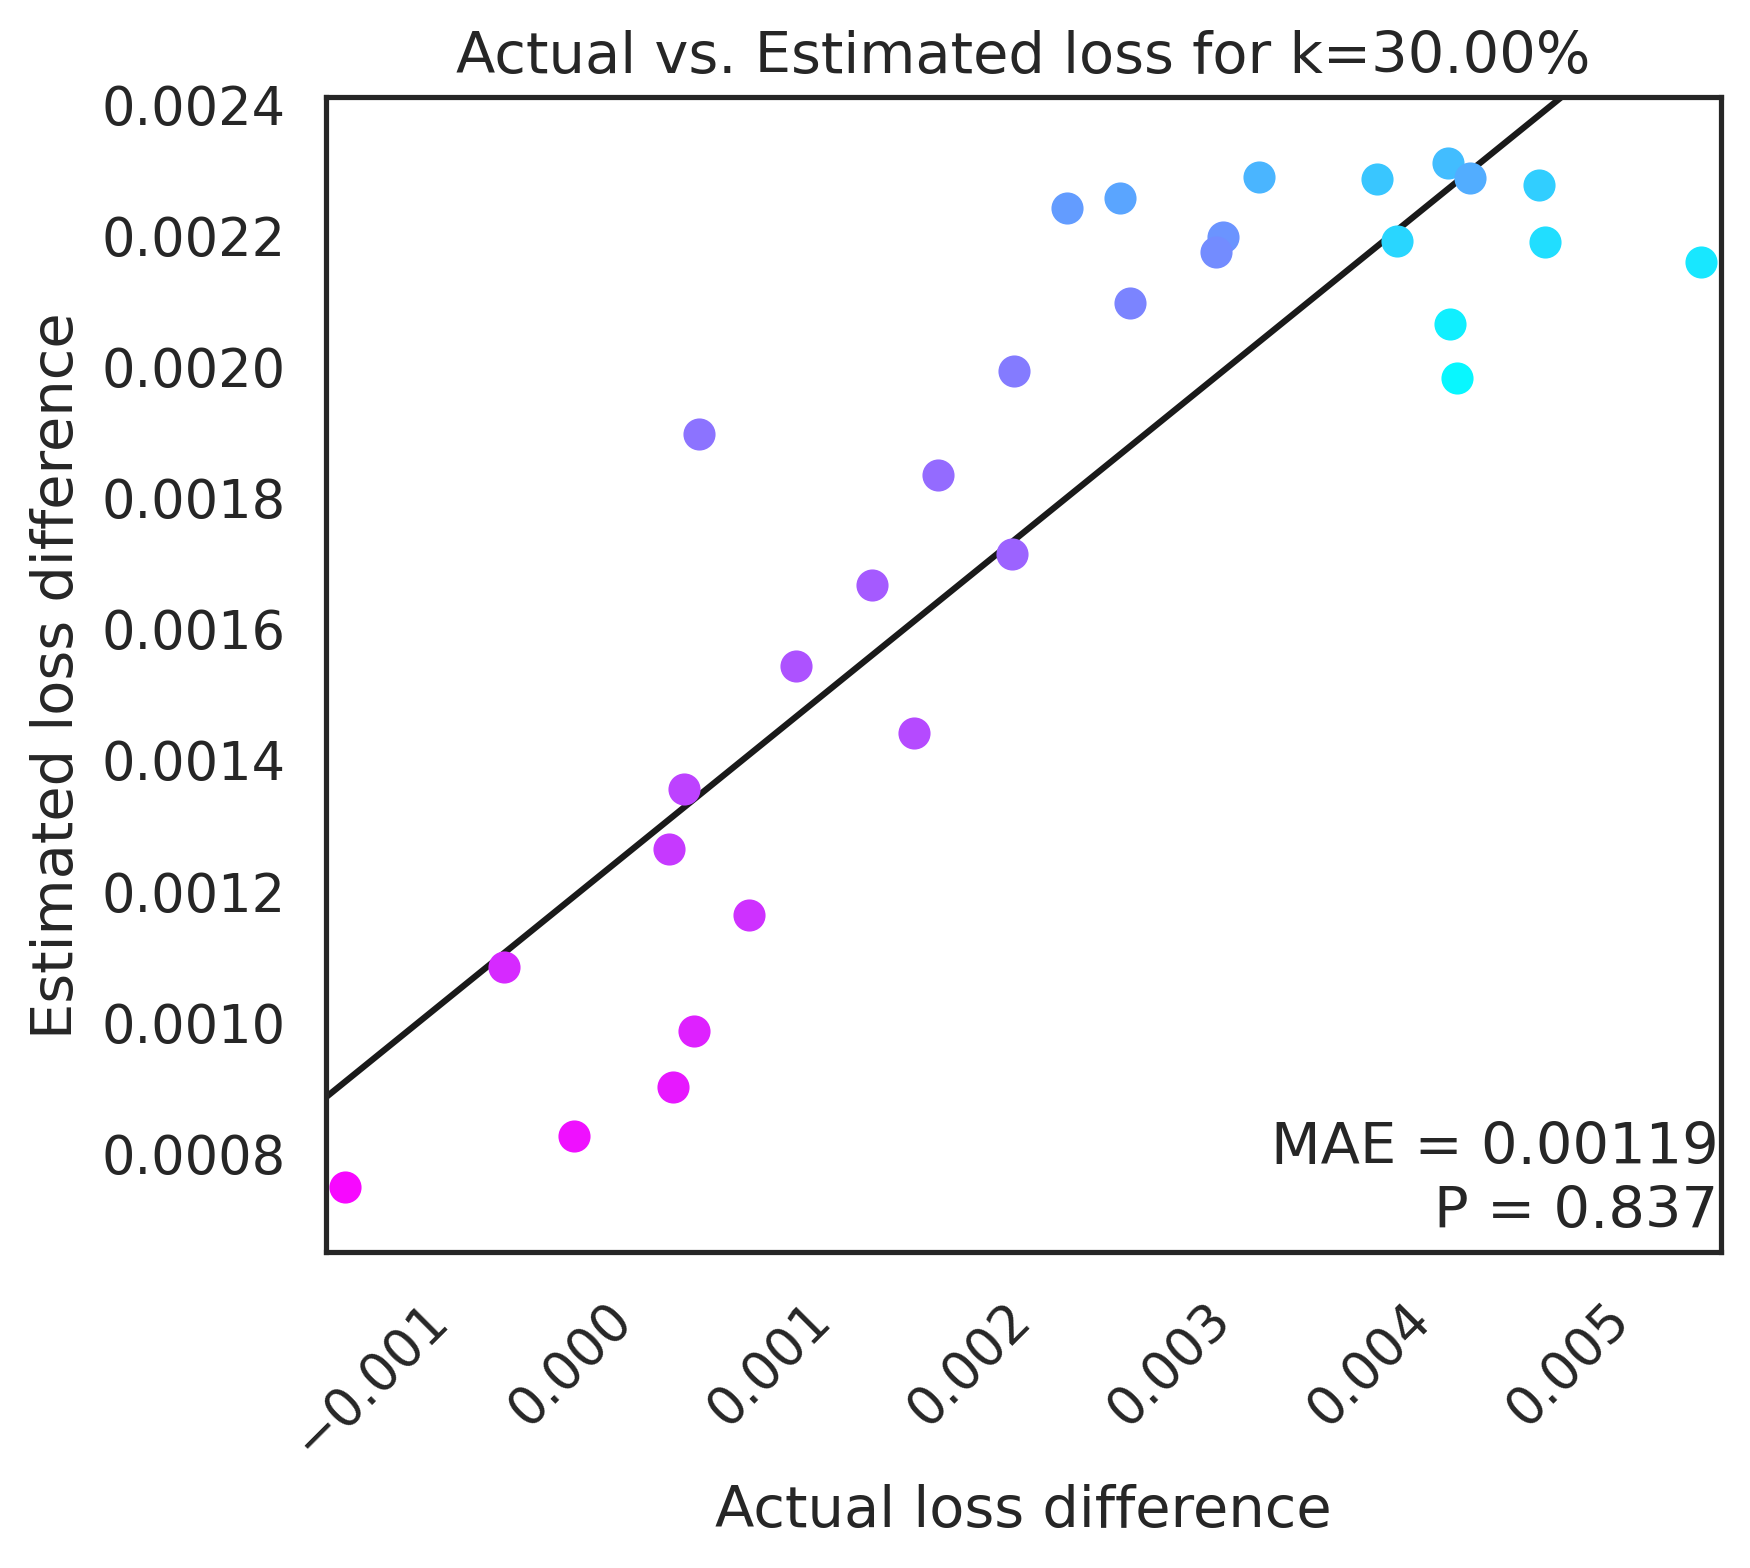


Round 3

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

k: 30
ep: 0.001


IHVP sample 2: 100%|████████████████████████████████████████████████| 7500/7500 [00:20<00:00, 373.07it/s, est norm=2.78]


Approx difference: 0.00222
True difference: 0.00479
ep: 0.17337931034482756
Approx difference: 0.00233
True difference: 0.00640
ep: 0.3457586206896551
Approx difference: 0.00237
True difference: 0.00602
ep: 0.5181379310344827
Approx difference: 0.00239
True difference: 0.00686
ep: 0.6905172413793103
Approx difference: 0.00236
True difference: 0.00679
ep: 0.8628965517241378
Approx difference: 0.00249
True difference: 0.00654
ep: 1.0352758620689653
Approx difference: 0.00246
True difference: 0.00696
ep: 1.207655172413793
Approx difference: 0.00255
True difference: 0.00660
ep: 1.3800344827586204
Approx difference: 0.00254
True difference: 0.00600
ep: 1.5524137931034478
Approx difference: 0.00244
True difference: 0.00456
ep: 1.7247931034482755
Approx difference: 0.00243
True difference: 0.00529
ep: 1.8971724137931032
Approx difference: 0.00243
True difference: 0.00328
ep: 2.0695517241379306
Approx difference: 0.00239
True difference: 0.00451
ep: 2.241931034482758
Approx difference: 0.00233

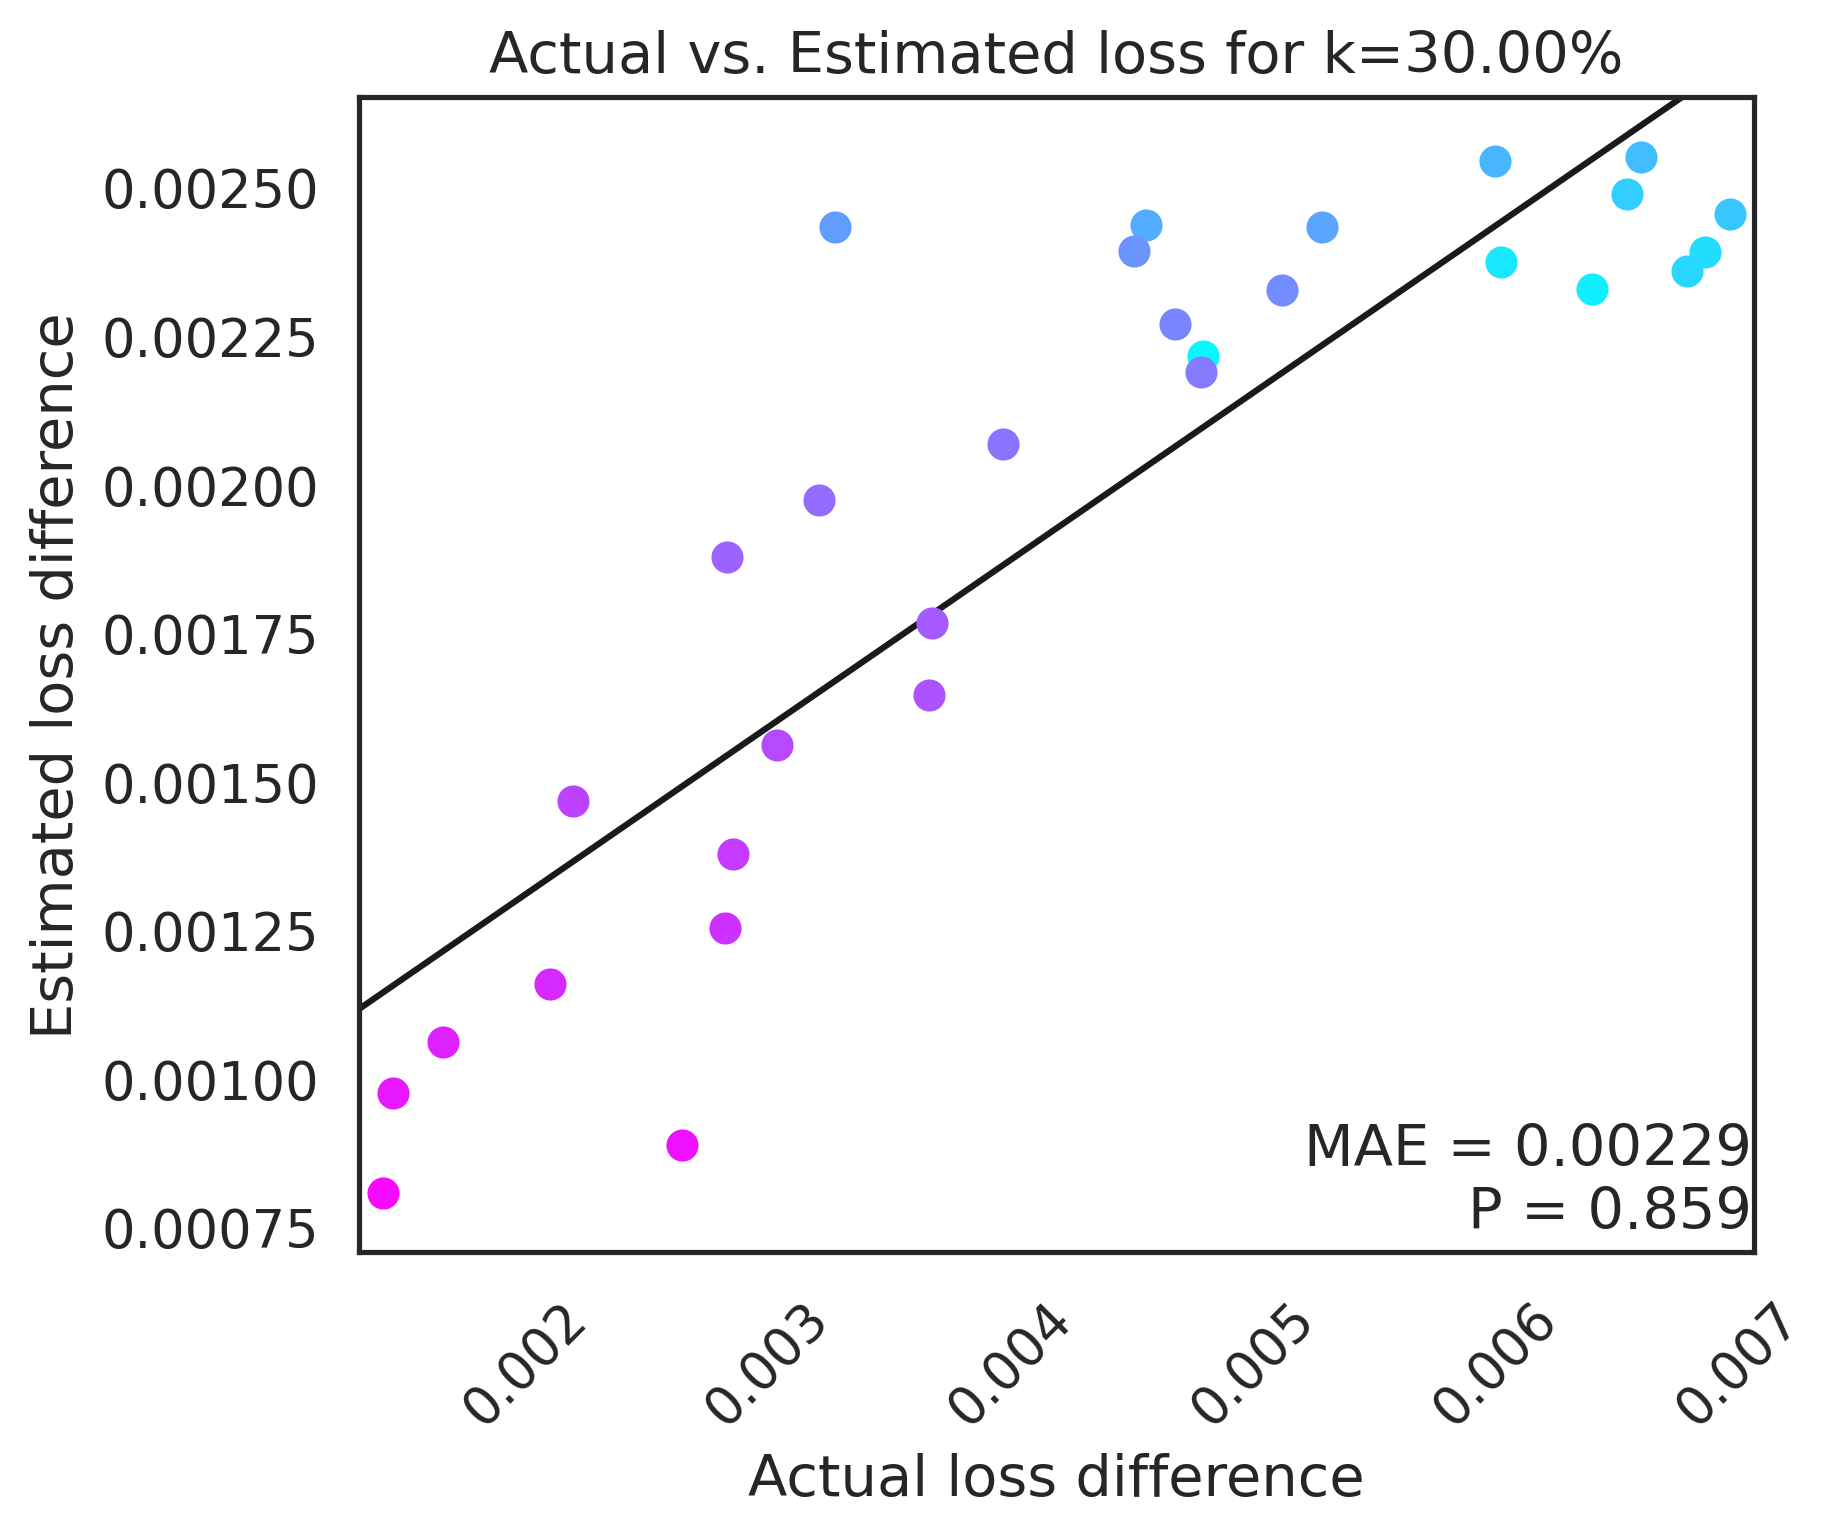


Round 4

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

k: 30
ep: 0.001


IHVP sample 2: 100%|████████████████████████████████████████████████| 7500/7500 [00:17<00:00, 427.40it/s, est norm=3.06]


Approx difference: 0.00176
True difference: 0.00503
ep: 0.17337931034482756
Approx difference: 0.00187
True difference: 0.00450
ep: 0.3457586206896551
Approx difference: 0.00193
True difference: 0.00523
ep: 0.5181379310344827
Approx difference: 0.00199
True difference: 0.00528
ep: 0.6905172413793103
Approx difference: 0.00198
True difference: 0.00576
ep: 0.8628965517241378
Approx difference: 0.00207
True difference: 0.00461
ep: 1.0352758620689653
Approx difference: 0.00209
True difference: 0.00467
ep: 1.207655172413793
Approx difference: 0.00213
True difference: 0.00423
ep: 1.3800344827586204
Approx difference: 0.00205
True difference: 0.00389
ep: 1.5524137931034478
Approx difference: 0.00211
True difference: 0.00396
ep: 1.7247931034482755
Approx difference: 0.00204
True difference: 0.00285
ep: 1.8971724137931032
Approx difference: 0.00203
True difference: 0.00408
ep: 2.0695517241379306
Approx difference: 0.00200
True difference: 0.00305
ep: 2.241931034482758
Approx difference: 0.00196

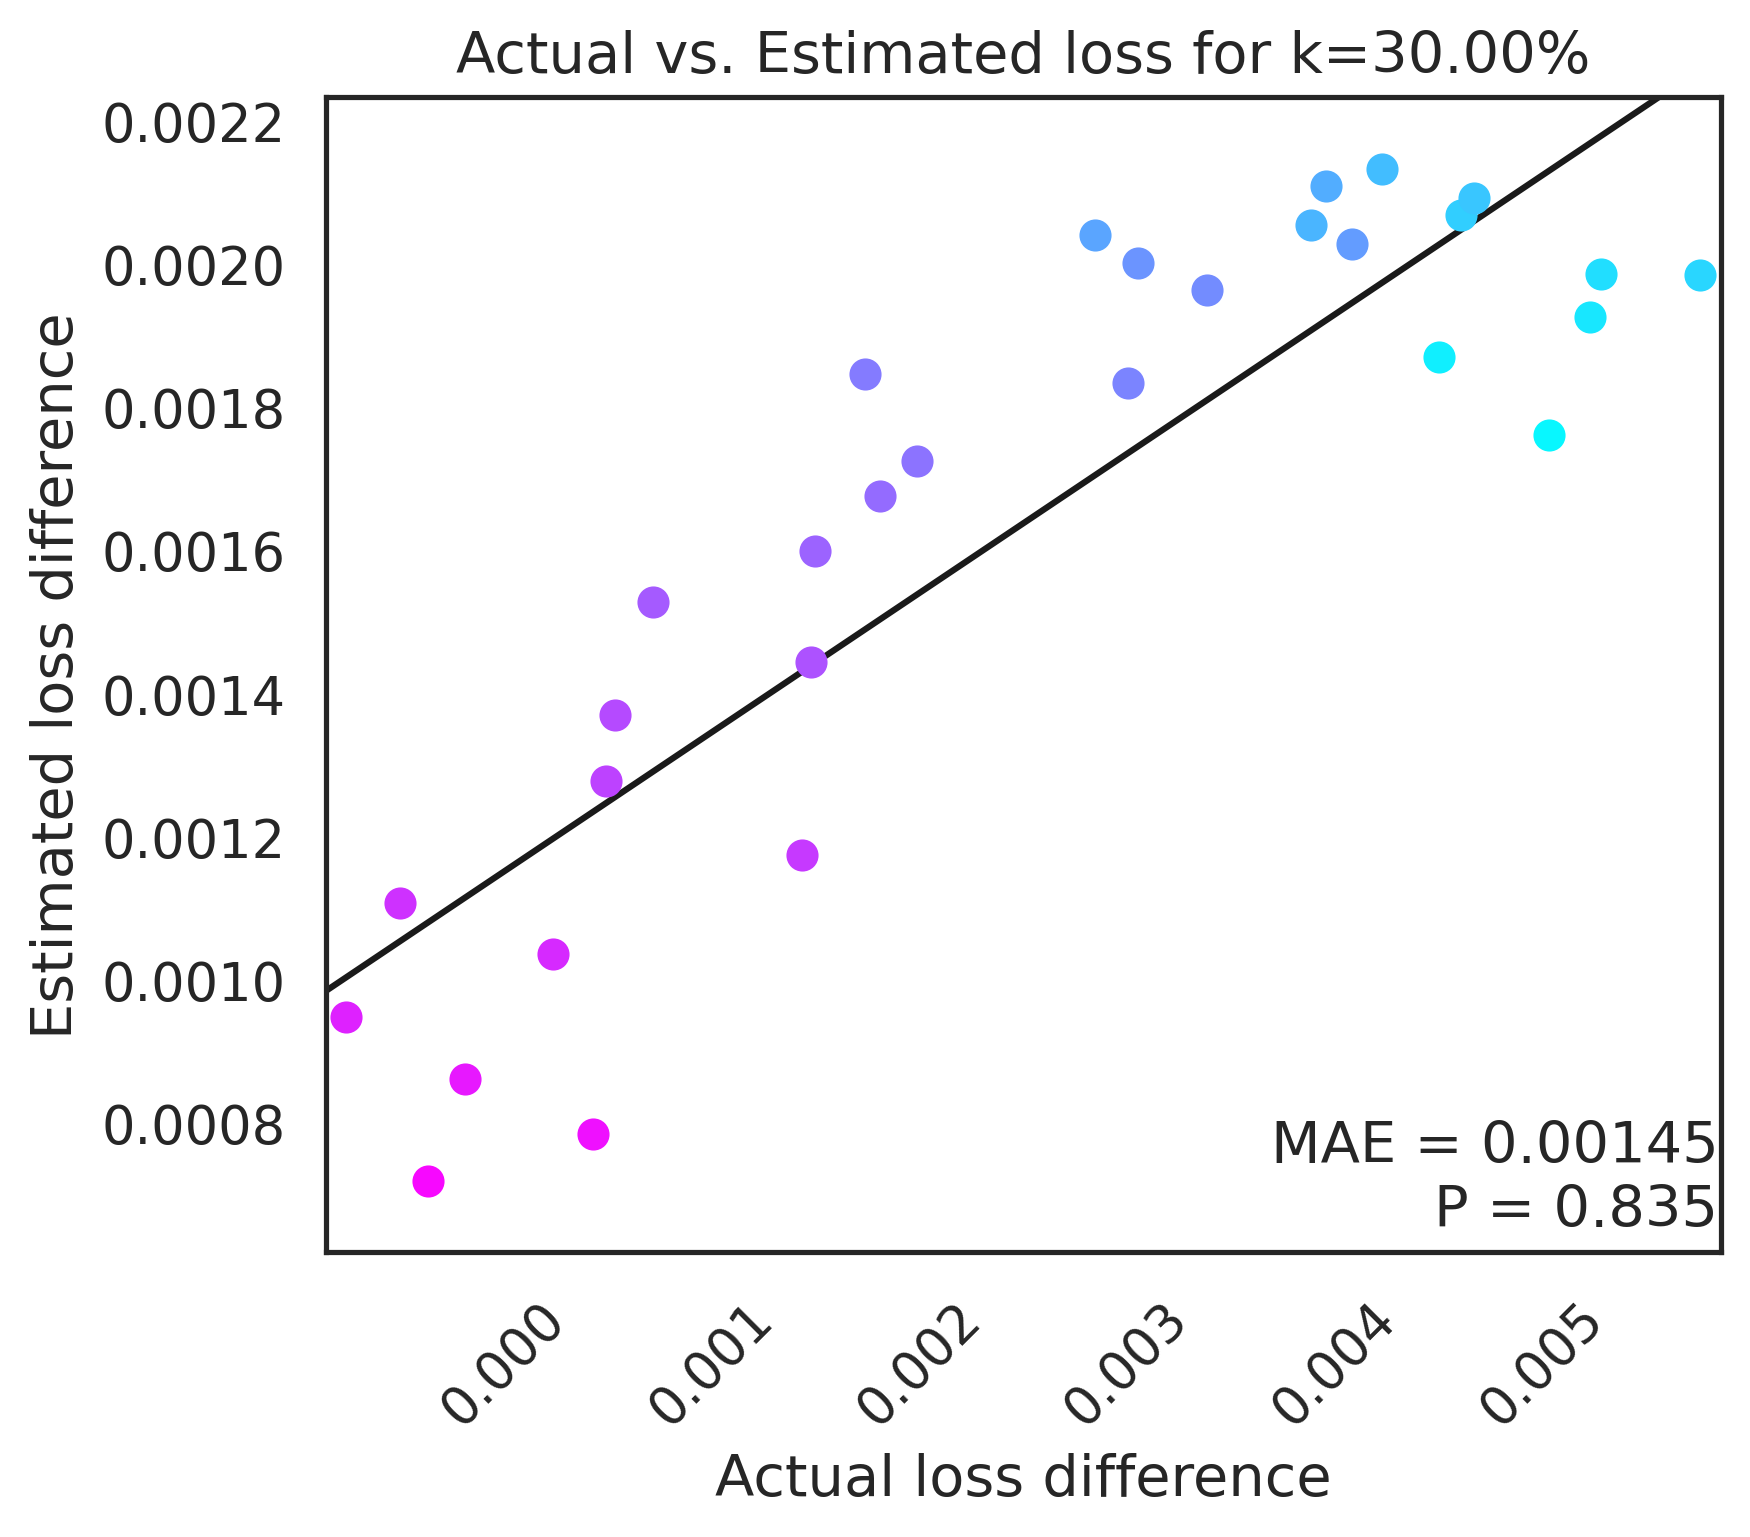


Round 5

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

k: 30
ep: 0.001


IHVP sample 2: 100%|█████████████████████████████████████████████████| 7500/7500 [00:18<00:00, 399.95it/s, est norm=2.8]


Approx difference: 0.00147
True difference: 0.00525
ep: 0.17337931034482756
Approx difference: 0.00144
True difference: 0.00570
ep: 0.3457586206896551
Approx difference: 0.00156
True difference: 0.00460
ep: 0.5181379310344827
Approx difference: 0.00155
True difference: 0.00509
ep: 0.6905172413793103
Approx difference: 0.00161
True difference: 0.00582
ep: 0.8628965517241378
Approx difference: 0.00167
True difference: 0.00496
ep: 1.0352758620689653
Approx difference: 0.00162
True difference: 0.00431
ep: 1.207655172413793
Approx difference: 0.00174
True difference: 0.00388
ep: 1.3800344827586204
Approx difference: 0.00169
True difference: 0.00460
ep: 1.5524137931034478
Approx difference: 0.00170
True difference: 0.00319
ep: 1.7247931034482755
Approx difference: 0.00166
True difference: 0.00307
ep: 1.8971724137931032
Approx difference: 0.00171
True difference: 0.00319
ep: 2.0695517241379306
Approx difference: 0.00167
True difference: 0.00263
ep: 2.241931034482758
Approx difference: 0.00159

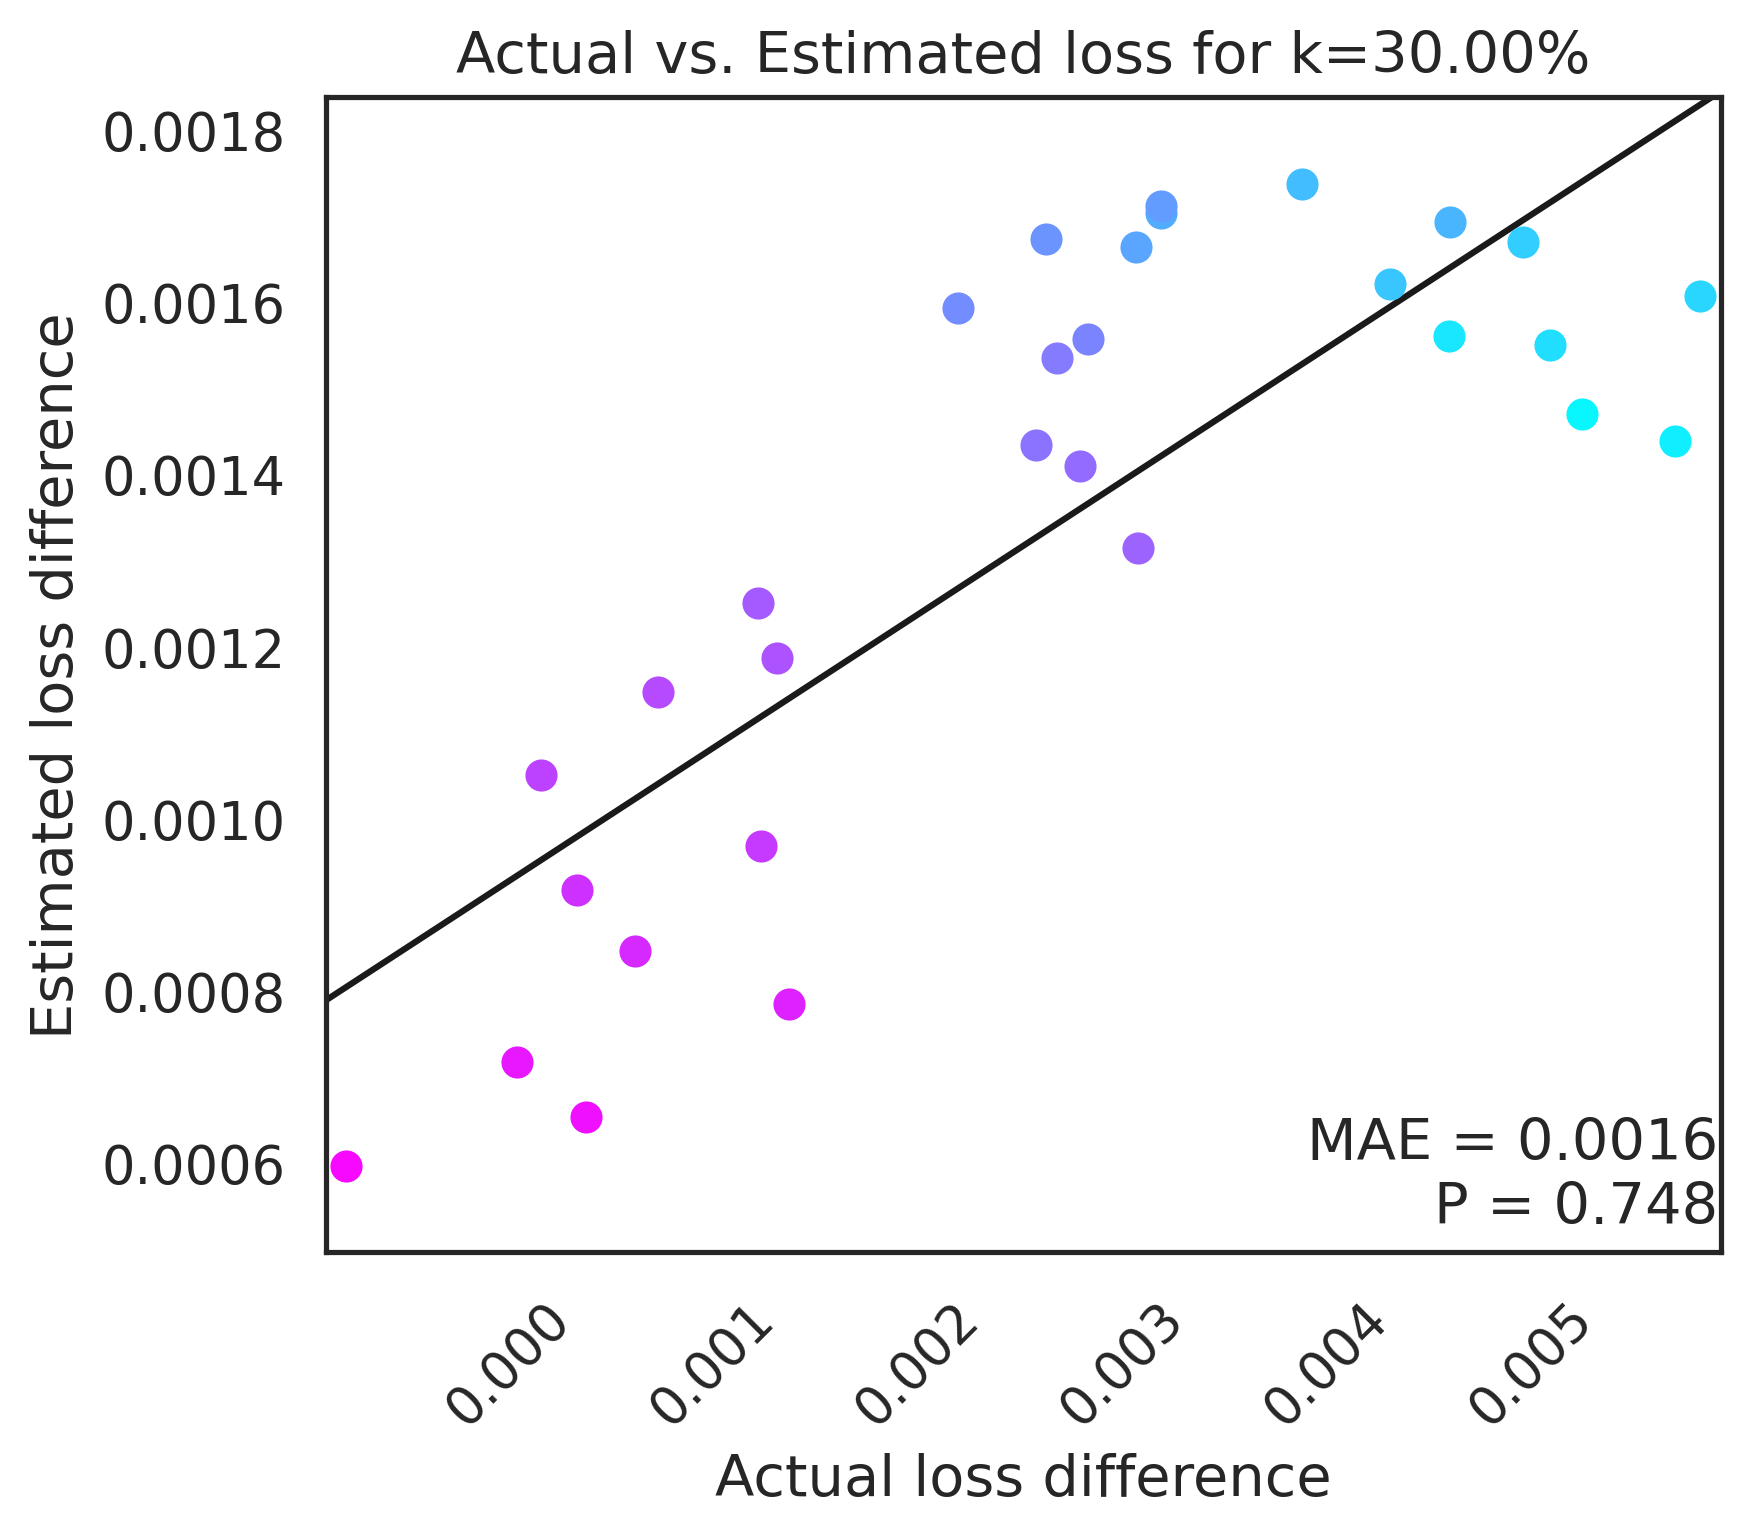

In [21]:
all_orig_loss_e_k, all_est_loss_e_k, all_time = Main('mnist', epsilons, k, rounds)

with open('all_orig_loss_e_k_mnist_flc.txt', "wb") as file:   #Pickling
    pickle.dump(all_orig_loss_e_k, file)

with open('all_est_loss_e_k_mnist_flc.txt', "wb") as file2:   #Pickling
    pickle.dump(all_est_loss_e_k, file2)

In [22]:
with open('all_orig_loss_e_k_mnist_flc.txt', 'rb') as f:
    all_orig_loss_e_k = pickle.load(f)
    
with open('all_est_loss_e_k_mnist_flc.txt', 'rb') as f:
    all_est_loss_e_k = pickle.load(f)

In [23]:
# [actual, estimate]

sum_orig_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_est_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_time = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]

avg_orig_loss = []
avg_est_loss = []
avg_time = []

for round_ in range(len(all_orig_loss_e_k)):
    for e in range(len(epsilons)):
        for k_ in range(len(k)):
            sum_orig_loss_e_k[e][k_] = sum_orig_loss_e_k[e][k_] + all_orig_loss_e_k[round_][e][k_]
            sum_est_loss_e_k[e][k_] = sum_est_loss_e_k[e][k_] + all_est_loss_e_k[round_][e][k_]
            sum_time[e][k_] = sum_time[e][k_] + all_time[round_][e][k_]

for e in range(len(epsilons)):
    avg_orig_loss.append([ elem / len(all_orig_loss_e_k) for elem in sum_orig_loss_e_k[e]])
    avg_est_loss.append([elem/ len(all_orig_loss_e_k) for elem in sum_est_loss_e_k[e]])
    avg_time.append([elem/ len(all_orig_loss_e_k) for elem in sum_time[e]])

k_e_orig = [[] for _ in range(len(k))]
k_e_est = [[] for _ in range(len(k))]

for e in range(len(epsilons)):
    for k_ in range(len(k)):
        k_e_orig[k_].append(avg_orig_loss[e][k_])
        k_e_est[k_].append(avg_est_loss[e][k_])

averaged_time = []

for e in range(len(epsilons)):
    averaged_time.append(sum_time[e][0])

average_time_final = sum(averaged_time) / len(averaged_time)

IndexError: list index out of range

In [ ]:
for i in range(len(k_e_orig)):
    visualize_result(k_e_orig[i], k_e_est[i], epsilons, k[i])